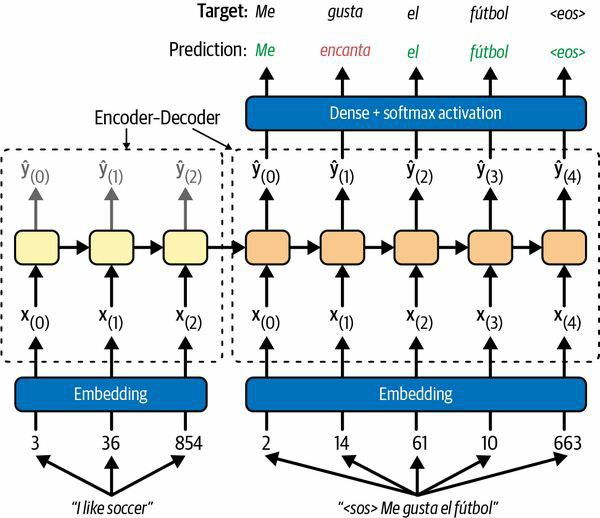

In [1]:
from IPython import display
import pathlib
import numpy as np
import tensorflow as tf

img = tf.io.read_file(filename="extras/translation_model.png")
img2 = tf.io.read_file(filename="extras/inference_time.png")
display.Image(img.numpy(), width=500)

Each word is initially represented by its ID (e.g., 854 for the word “soccer”).
Next, an Embedding layer returns the word embedding. These word
embeddings are then fed to the encoder and the decoder. This is very much like a regular
classification task, and indeed you can train the model using the
"sparse_categorical_crossentropy" loss, much like we did in the char-RNN
model.

Note that at inference time (after training), you will not have the target
sentence to feed to the decoder. Instead, you need to feed it the word that it
has just output at the previous step.

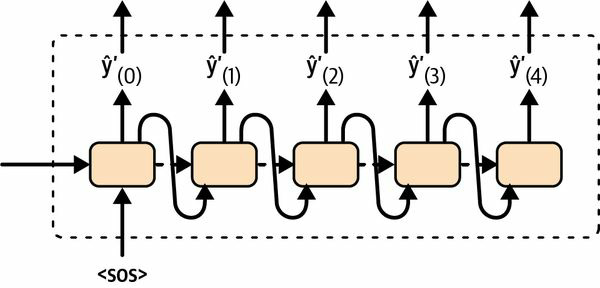

In [2]:
display.Image(img2.numpy(), width=500)

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", url, cache_dir="extras/.", extract=True)
text = (pathlib.Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 1s 0us/step


In [4]:
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [5]:
for i in range(3):
    print(sentences_en[i], "==>", sentences_es[i])

How boring! ==> Qué aburrimiento!
I love sports. ==> Adoro el deporte.
Would you like to swap jobs? ==> Te gustaría que intercambiemos los trabajos?


Next, let’s create two TextVectorization layers—one per language—and
adapt them to the text:

In [6]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

*Notes:*

* We limit the vocabulary size to 1,000, which is quite small. That’s
because the training set is not very large, and because using a small
value will speed up training. State-of-the-art translation models typically
use a much larger vocabulary (e.g., 30,000)

* Since all sentences in the dataset have a maximum of 50 words, we set
output_sequence_length to 50: this way the input sequences will
automatically be padded with zeros until they are all 50 tokens long. If
there was any sentence longer than 50 tokens in the training set, it would
be cropped to 50 tokens.

* For the Spanish text, we add “startofseq” and “endofseq” to each
sentence when adapting the TextVectorization layer: we will use these
words as SOS and EOS tokens. You could use any other words, as long
as they are not actual Spanish words.

In [7]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [8]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [9]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])

# the decoder's inputs are the Spanish sentences plus <SOS> prefix.
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
# the targets are the Spanish sentences plus an <EOS> suffix.
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

OK, we’re now ready to build our translation model. We will use the
functional API for that since the model is not sequential. It requires two text
inputs—one for the encoder and one for the decoder

In [10]:
encoder_inputs = tf.keras.layers.Input([], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input([], dtype=tf.string)

Next, we need to encode these sentences using the TextVectorization layers
we prepared earlier, followed by an Embedding layer for each language, with
mask_zero=True to ensure masking is handled automatically. The embedding
size is a hyperparameter you can tune, as always:

In [11]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
decoder_embedding_layer = tf.keras.layers.Embedding(
    vocab_size, embed_size, mask_zero=True
)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [12]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

** ``

To keep things simple, we just used a single LSTM layer, but you could stack
several of them. We also set return_state=True to get a reference to the
layer’s final state. Since we’re using an LSTM layer, there are actually two
states: the short-term state and the long-term state. The layer returns these
states separately, which is why we had to write *encoder_state to group both
states in a list.⁠ Now we can use this (double) state as the initial state of
the decoder:

In [13]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [14]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

Create a Keras Model, compile and train:

In [15]:
model = tf.keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba]
)
code = """
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))"""
display.display(display.Markdown("```python\n{}\n".format(code)))

```python

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))


In [16]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq" + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

### Bidirectional RNN's

At each time step, a regular recurrent layer only looks at past and present
inputs before generating its output. In other words, it is causal, meaning it
cannot look into the future. This type of RNN makes sense when forecasting
time series, or in the decoder of a sequence-to-sequence (seq2seq) model. But
for tasks like text classification, or in the encoder of a seq2seq model, it is
often preferable to look ahead at the next words before encoding a given
word.

In [17]:
# Keras implementation
tf.random.set_seed(42)
encoder_ = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_state=True))

In [18]:
encoder_outputs_, *encoder_state_ = encoder_(encoder_embeddings)
encoder_state_ = [
    tf.concat(encoder_state_[::2], axis=-1),  # short-term (0, 2)
    tf.concat(encoder_state_[1::2], axis=-1),
]  # long-term (1, 3)

In [19]:
code = """
decoder_ = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs_ = decoder_(decoder_embeddings, initial_state=encoder_state_)
output_layer_ = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba_ = output_layer_(decoder_outputs_)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba_])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))"""
display.display(display.Markdown("```python\n{}\n".format(code)))

```python

decoder_ = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs_ = decoder_(decoder_embeddings, initial_state=encoder_state_)
output_layer_ = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba_ = output_layer_(decoder_outputs_)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba_])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))
